# chips-net analysis

This notebook contains the full analysis of chipsnet showing the full path taken to the current final version...

- [x] [Exploring the data: looking at the truth distributions, event image representations and cuts](#section_1).
- [x] [Which event image representation is best?](#section_2).
- [x] [Which channels should we use?](#section_3).
- [x] [Which training sample is best? (beam flux vs uniform)](#section_4).
- [x] [Which categorisation works best?](#section_5).
- [x] [Different model architectures: which works best](#section_6).
- [x] [Trying a multi-task model: what to include](#section_7).
- [x] [Model calibration sensitivity: can we shift things up and down?](#section_8).
- [ ] [Neutrino energy estimation](#section_9).
- [x] [Explanation clustering: PCA and t-SNE.](#section_10).
- [x] [Explanation activations](#section_11)
- [ ] [Final model/models performance and comparison with lagacy reco and PID](#section_12)

In [1]:
# Default input parameters for this notebook, they are overridden by 'papermill' at runtime if specified
config_path = "../config/eval.yaml"
save_path = "../data/output/"
nuel_map_file = "/unix/chips/jtingey/production/beam_all/nuel/map/chips_1200/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/production/beam_all/numu/map/chips_1200/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/production/cosmic_all/map/chips_1200/selected_000_sim_map.root"

In [2]:
# Standard inports
import os
import logging
import importlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep

# Setup Tensorflow with correct logging and GPU's for inference
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
import chipsnet.plotting

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}
plt.style.use([hep.style.ROOT, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)
    importlib.reload(chipsnet.plotting)
    
def save(name):
    plt.savefig('{}{}.pgf'.format(save_path, name))
    plt.savefig('{}{}.pdf'.format(save_path, name))
    plt.show()   
    
reload()
config = chipsnet.config.get(config_path)

<a id='section_1'></a>

## Exploring the data: looking at the truth distributions and event image representations.

First let's explore the input data we have to work with...

In [4]:
v_cth_flux_cos_ev, v_cth_flux_cos_out = chipsnet.utils.process_ds(config, "v_cth_flux_cos", verbose=True)
v_cth_uniform_cos_ev, v_cth_uniform_cos_out = chipsnet.utils.process_ds(config, "v_cth_uniform_cos")

Processing v_cth_flux_cos... 

Nuel:   26651, weight: 0.00146, actual: 38.88
Anuel:  25805, weight: 0.00010, actual: 2.53
Numu:   25224, weight: 0.13294, actual: 3353.22
Anumu:  24720, weight: 0.00297, actual: 73.36
Cosmic: 25600, weight: 47.293, actual: 1210697.86
Nuel-CC: total 44335, survived: 0.9291755949024473
Numu-CC: total 43111, survived: 0.756373083435782
NC: total 14954, survived: 0.4079176140163167
Cosmic: total 25600, survived: 0.132421875
took 24.53 seconds
Processing v_cth_uniform_cos... took 22.00 seconds


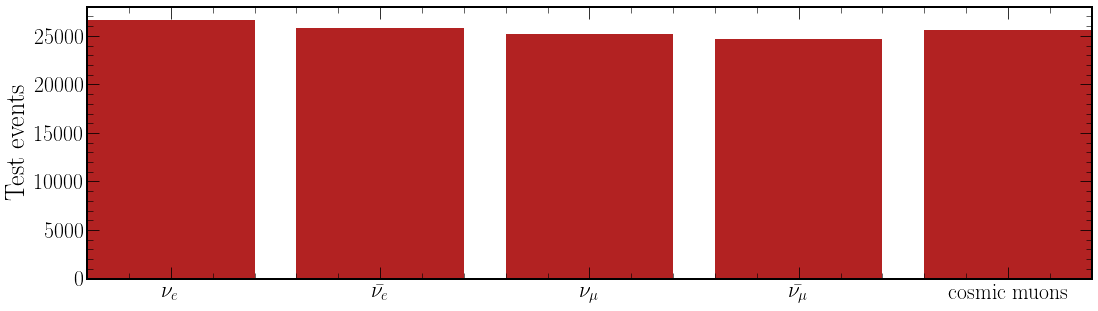

In [5]:
# change variable name for dataframes to make everything easier
events_u = v_cth_uniform_cos_ev  
events_b = v_cth_flux_cos_ev

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
cats = np.arange(5)
axs.bar(
    cats, 
    [len(events_b[(events_b.t_nu_type == 0) & (events_b.t_sign_type == 0) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 0) & (events_b.t_sign_type == 1) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 1) & (events_b.t_sign_type == 0) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 1) & (events_b.t_sign_type == 1) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[events_b.t_cosmic_cat == 1])],
    color="firebrick")
axs.set_xticks(cats)
axs.set_xticklabels(('$\\nu_{e}$', '$\\bar{\\nu_{e}}$', '$\\nu_{\mu}$', '$\\bar{\\nu_{\mu}}$', 'cosmic muons'))
axs.set_ylabel("Test events")
save("nu_types")

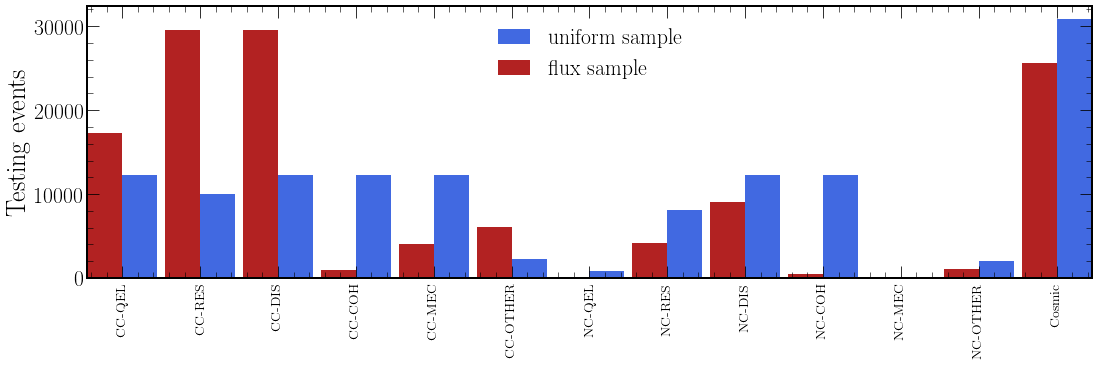

In [6]:
chipsnet.plotting.plot_cats(events_u, events_b, chipsnet.data.MAP_INT_TYPE, save_path)

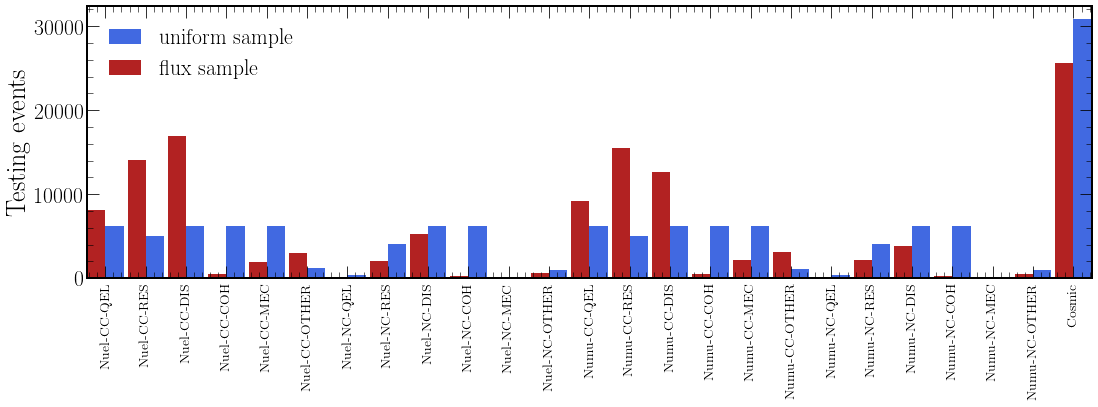

In [7]:
chipsnet.plotting.plot_cats(events_u, events_b, chipsnet.data.MAP_ALL_CAT, save_path)

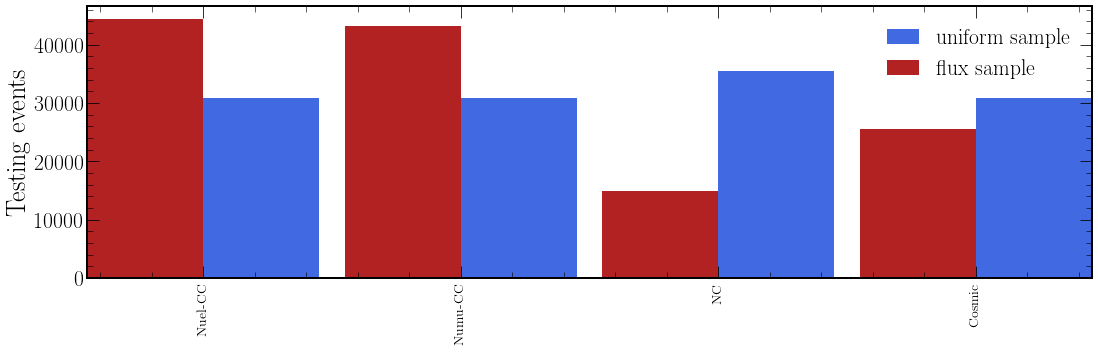

In [8]:
chipsnet.plotting.plot_cats(events_u, events_b, chipsnet.data.MAP_FULL_COMB_CAT, save_path)

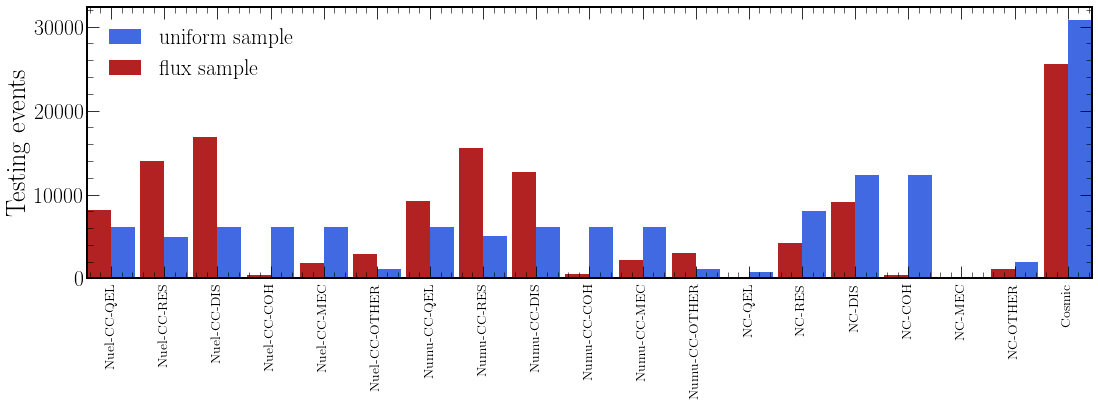

In [9]:
chipsnet.plotting.plot_cats(events_u, events_b, chipsnet.data.MAP_NU_NC_COMB_CAT, save_path)

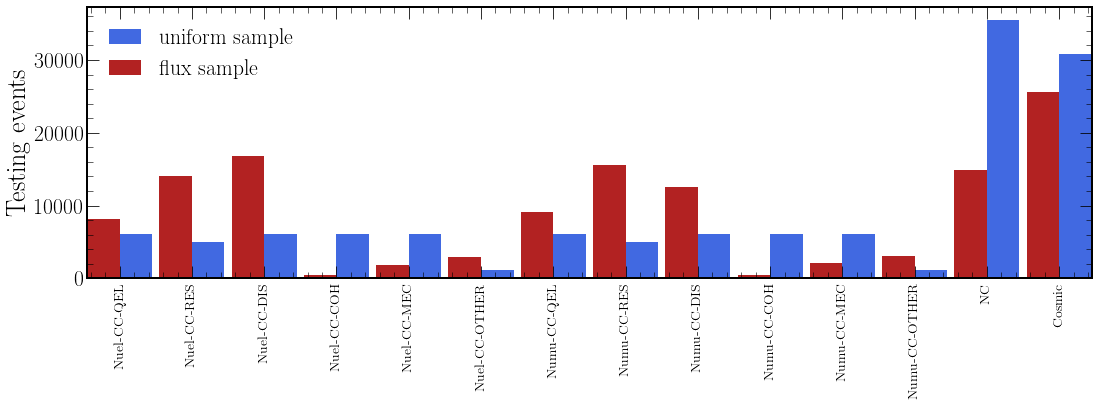

In [10]:
chipsnet.plotting.plot_cats(events_u, events_b, chipsnet.data.MAP_NC_COMB_CAT, save_path)

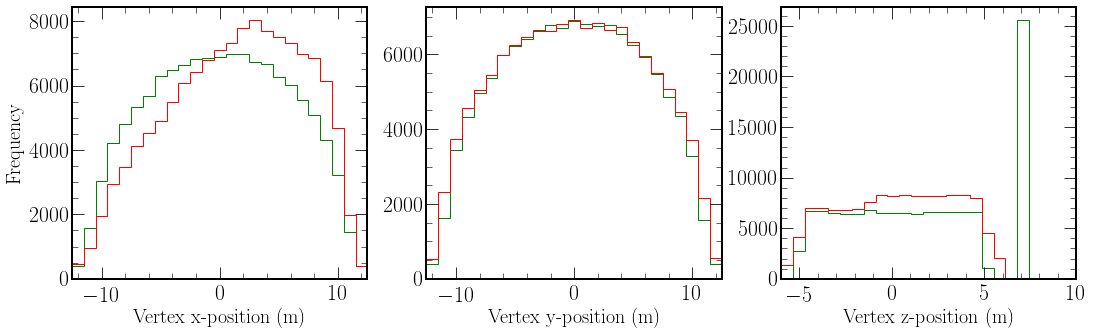

In [11]:
line_g = matplotlib.lines.Line2D([], [], c='green')
line_r = matplotlib.lines.Line2D([], [], c='red')

fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(events_b["t_vtxX"]/100, range=(-12.5, 12.5), bins=25, color='green', histtype='step')
axs[0].hist(events_b["r_vtxX"]*1250/100, range=(-12.5, 12.5), bins=25, color='red', histtype='step')
#axs[0].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[0].set_xlabel('Vertex x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events_b["t_vtxY"]/100, range=(-12.5, 12.5), bins=25, color='green', histtype='step')
axs[1].hist(events_b["r_vtxY"]*1250/100, range=(-12.5, 12.5), bins=25, color='red', histtype='step')
#axs[1].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[1].set_xlabel('Vertex y-position (m)', fontsize=20)

axs[2].hist(events_b["t_vtxZ"]/100, range=(-6, 10), bins=25, color='green', histtype='step')
axs[2].hist(events_b["r_vtxZ"]*600/100, range=(-6, 10), bins=25, color='red', histtype='step')
#axs[2].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[2].set_xlabel('Vertex z-position (m)', fontsize=20)
save("vtx_positions")

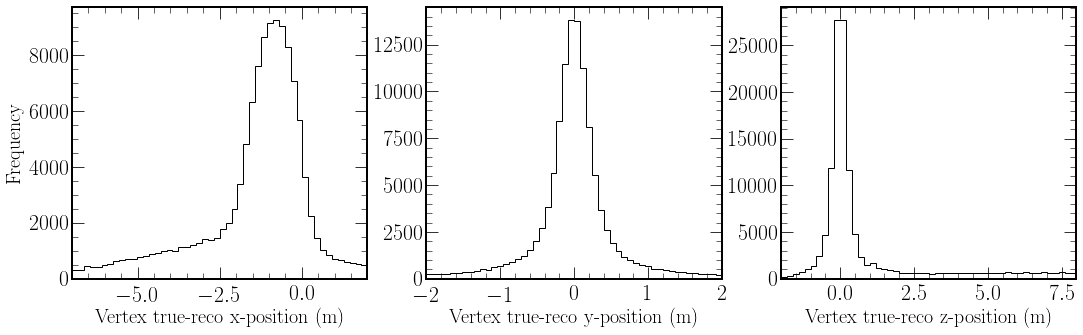

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(events_b["t_vtxX"]/100-(events_b["r_vtxX"]*1250/100), range=(-7, 2), bins=50, color='black', histtype='step')
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events_b["t_vtxY"]/100-(events_b["r_vtxY"]*1250/100), range=(-2, 2), bins=50, color='black', histtype='step')
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=20)

axs[2].hist(events_b["t_vtxZ"]/100-(events_b["r_vtxZ"]*600/100), range=(-2, 8), bins=50, color='black', histtype='step')
axs[2].set_xlabel('Vertex true-reco z-position (m)', fontsize=20)
save("true_reco_vtx")

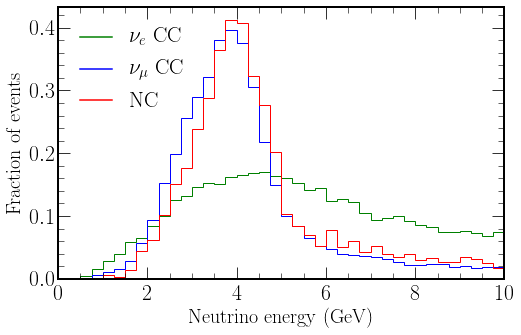

In [13]:
line_g = matplotlib.lines.Line2D([], [], c='green')
line_b = matplotlib.lines.Line2D([], [], c='blue')
line_r = matplotlib.lines.Line2D([], [], c='red')

fig, axs = plt.subplots(1, 1, figsize=(8, 5), gridspec_kw={'hspace': 0.3})
axs.hist(events_b[events_b["t_comb_cat"] == 0]["t_nuEnergy"]/1000, weights=events_b[events_b["t_comb_cat"] == 0]["w"],
         range=(0, 10), bins=40, color='green', histtype='step', density=True)
axs.hist(events_b[events_b["t_comb_cat"] == 1]["t_nuEnergy"]/1000, weights=events_b[events_b["t_comb_cat"] == 1]["w"],
         range=(0, 10), bins=40, color='blue', histtype='step', density=True)
axs.hist(events_b[events_b["t_comb_cat"] == 2]["t_nuEnergy"]/1000, weights=events_b[events_b["t_comb_cat"] == 2]["w"],
         range=(0, 10), bins=40, color='red', histtype='step', density=True)
axs.legend(loc="upper left", handles=[line_g, line_b, line_r], labels=["$\\nu_{e}$ CC", "$\\nu_{\mu}$ CC", "NC"])
axs.set_xlabel('Neutrino energy (GeV)', fontsize=20)
axs.set_ylabel('Fraction of events', fontsize=20)
save("nu_energies")

In [14]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_raw_charge_map_origin": [], "r_raw_charge_map_iso": [], "r_raw_charge_map_vtx": [],
               "r_raw_time_map_origin": [], "r_raw_time_map_iso": [], "r_raw_time_map_vtx": [], "r_raw_hit_hough_map_vtx": []}
channel_hists = images_dict

In [15]:
# Load the images into the dictionary
import uproot
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_raw_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.47705780747902665


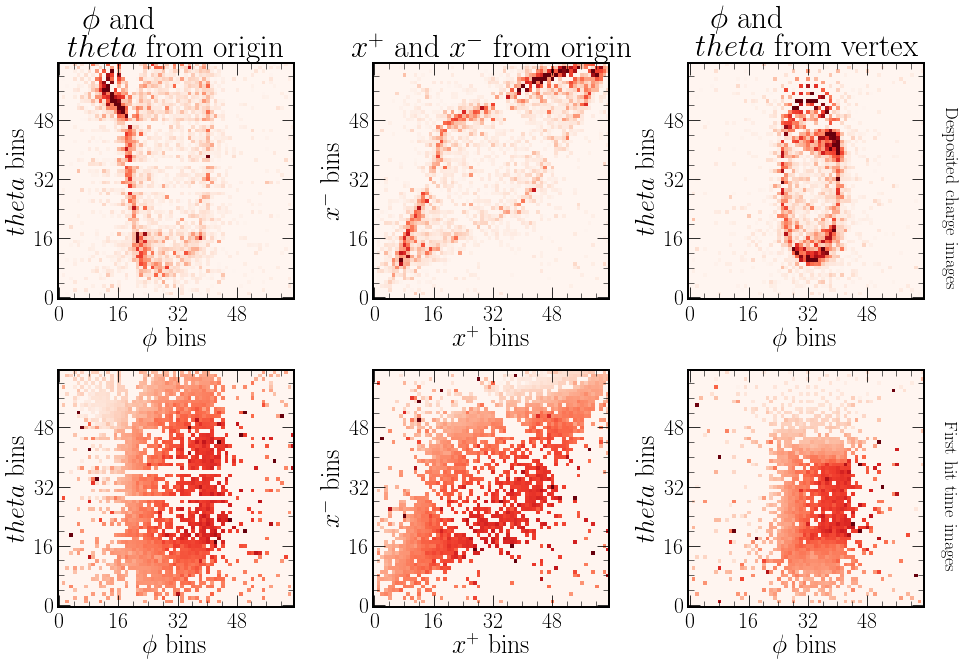

In [16]:
chipsnet.plotting.plot_hit_time(images_dict, 1, save_path)

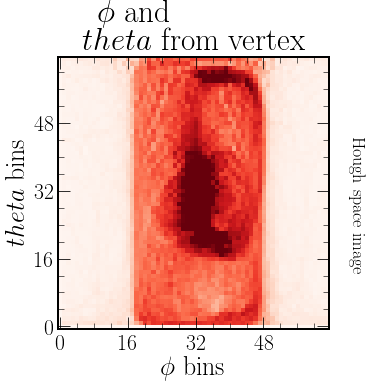

In [17]:
chipsnet.plotting.plot_hough(images_dict, 1, save_path)

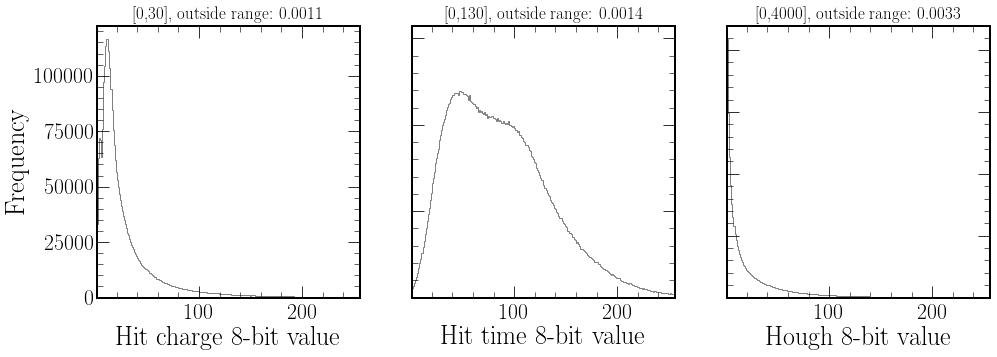

In [18]:
chipsnet.plotting.plot_8bit_range(images_dict, save_path=save_path)

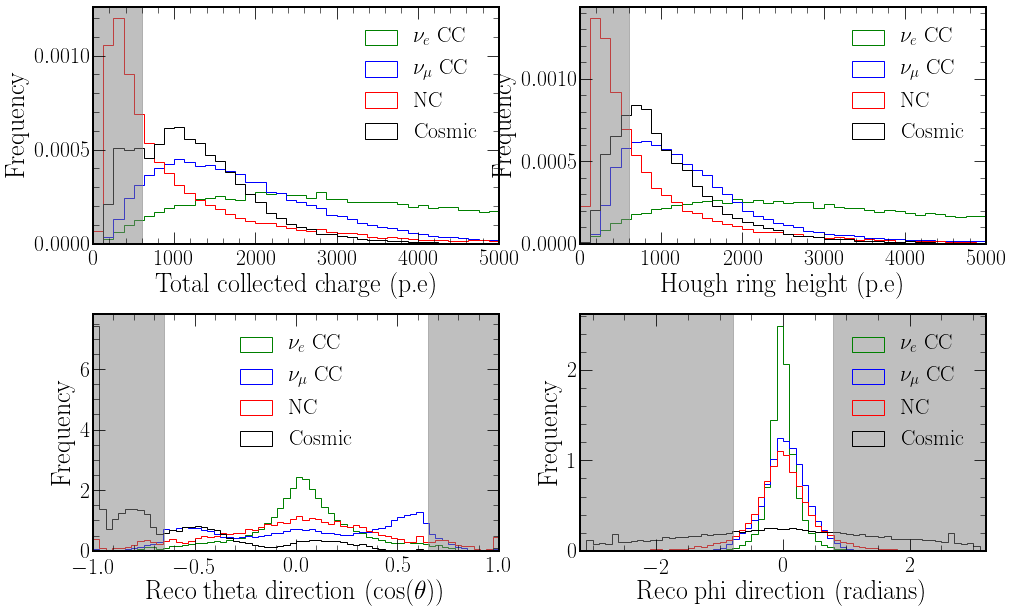

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
axs[0, 0].hist(events_b[events_b.t_comb_cat == 0]['r_raw_total_digi_q'], color='green',
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{e}$ CC")
axs[0, 0].hist(events_b[events_b.t_comb_cat == 1]['r_raw_total_digi_q'], color='blue', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{\mu}$ CC")
axs[0, 0].hist(events_b[events_b.t_comb_cat == 2]['r_raw_total_digi_q'], color='red', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="NC")
axs[0, 0].hist(events_b[events_b.t_comb_cat == 3]['r_raw_total_digi_q'], color='black', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="Cosmic")
axs[0, 0].set(xlabel='Total collected charge (p.e)', ylabel='Frequency')
axs[0, 0].axvspan(0, config.eval.cuts.q, alpha=0.5, color='grey')
axs[0, 0].legend()

axs[0, 1].hist(events_b[events_b.t_comb_cat == 0]['r_first_ring_height'], color='green',
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{e}$ CC")
axs[0, 1].hist(events_b[events_b.t_comb_cat == 1]['r_first_ring_height'], color='blue', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{\mu}$ CC")
axs[0, 1].hist(events_b[events_b.t_comb_cat == 2]['r_first_ring_height'], color='red', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="NC")
axs[0, 1].hist(events_b[events_b.t_comb_cat == 3]['r_first_ring_height'], color='black', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="Cosmic")
axs[0, 1].set(xlabel='Hough ring height (p.e)', ylabel='Frequency')
axs[0, 1].axvspan(0, config.eval.cuts.h, alpha=0.5, color='grey')
axs[0, 1].legend()

axs[1, 0].hist(events_b[events_b.t_comb_cat == 0]['r_dirTheta'], color='green',
               histtype='step', range=(-1, 1), bins=64, density=True, label="$\\nu_{e}$ CC")
axs[1, 0].hist(events_b[events_b.t_comb_cat == 1]['r_dirTheta'], color='blue', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="$\\nu_{\mu}$ CC")
axs[1, 0].hist(events_b[events_b.t_comb_cat == 2]['r_dirTheta'], color='red', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="NC")
axs[1, 0].hist(events_b[events_b.t_comb_cat == 3]['r_dirTheta'], color='black', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="Cosmic")
axs[1, 0].set(xlabel='Reco theta direction (cos($\\theta$))', ylabel='Frequency')
axs[1, 0].axvspan(-1, -config.eval.cuts.theta, alpha=0.5, color='grey')
axs[1, 0].axvspan(config.eval.cuts.theta, 1, alpha=0.5, color='grey')
axs[1, 0].legend()

axs[1, 1].hist(events_b[events_b.t_comb_cat == 0]['r_dirPhi']*3.14159, color='green',
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="$\\nu_{e}$ CC")
axs[1, 1].hist(events_b[events_b.t_comb_cat == 1]['r_dirPhi']*3.14159, color='blue', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="$\\nu_{\mu}$ CC")
axs[1, 1].hist(events_b[events_b.t_comb_cat == 2]['r_dirPhi']*3.14159, color='red', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="NC")
axs[1, 1].hist(events_b[events_b.t_comb_cat == 3]['r_dirPhi']*3.14159, color='black', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="Cosmic")
axs[1, 1].set(xlabel='Reco phi direction (radians)', ylabel='Frequency')
axs[1, 1].axvspan(-3.2, -config.eval.cuts.phi*3.14159, alpha=0.5, color='grey')
axs[1, 1].axvspan(config.eval.cuts.phi*3.14159, 3.2, alpha=0.5, color='grey')
axs[1, 1].legend()
save("simple_cuts")

In [20]:
# Tidy up
del v_cth_flux_cos_ev
del v_cth_flux_cos_out
del v_cth_uniform_cos_ev
del v_cth_uniform_cos_out

<a id='section_2'></a>

## Which event image representation is best? 

The theta/phi representation as viewed from the roughly reconstructed event vertex position seems to work best.

In [21]:
v_ct_flux_ev, v_ct_flux_out = chipsnet.utils.process_ds(config, "v_ct_flux", ["beam_v_ct"])
o_ct_flux_ev, o_ct_flux_out = chipsnet.utils.process_ds(config, "o_ct_flux", ["beam_o_ct"])
i_ct_flux_ev, i_ct_flux_out = chipsnet.utils.process_ds(config, "i_ct_flux", ["beam_i_ct"])

Processing v_ct_flux... found no image_2... took 132.57 seconds
Processing o_ct_flux... found no image_2... took 160.50 seconds
Processing i_ct_flux... found no image_2... took 144.01 seconds


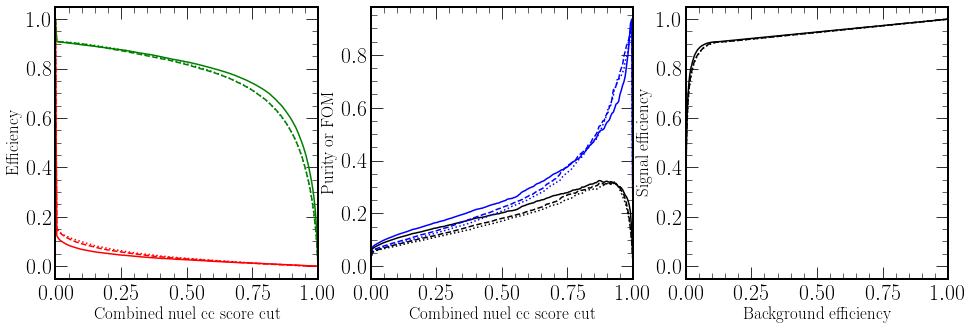

In [22]:
chipsnet.plotting.plot_curves([v_ct_flux_out, o_ct_flux_out, i_ct_flux_out], save_path+"img_repr_curves")

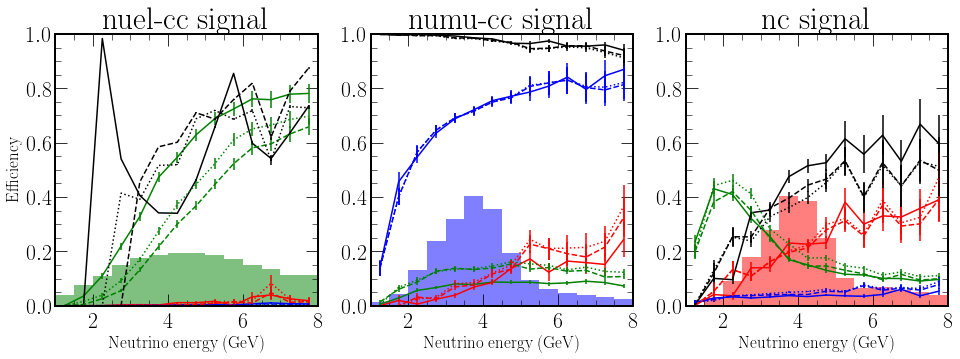

In [23]:
chipsnet.plotting.plot_e_hists([v_ct_flux_out, o_ct_flux_out, i_ct_flux_out], v_ct_flux_ev, save_path+"img_repr_hists")

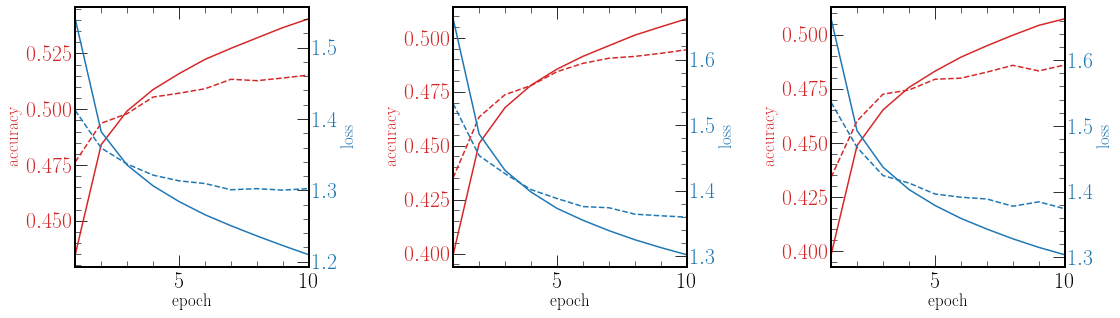

In [24]:
chipsnet.plotting.plot_history_comparison(config, ["beam_v_ct", "beam_o_ct", "beam_i_ct"], save_path+"img_repr_history")

In [25]:
chipsnet.utils.print_output_comparison([v_ct_flux_out, o_ct_flux_out, i_ct_flux_out])

Sig eff AUC: [0.778879490356895, 0.6854036321832653, 0.18679001347369945]
Bkg eff AUC: [0.03431001219983456, 0.02979972946241758, 0.029926205212637995]
Purity AUC: [0.2921164627916182, 0.9906598265757596, 0.5747157178751661]
FOM AUC: [0.20433158202078017, 0.6804736461145522, 0.09844429325570087]
ROC AUC: [0.941185396941298, 0.833516092873518, 0.5991662153410494]
              precision    recall  f1-score   support

     nuel-cc       0.93      0.91      0.92     55412
     numu-cc       0.97      0.94      0.96     53880
          nc       0.69      0.82      0.75     18708

    accuracy                           0.91    128000
   macro avg       0.87      0.89      0.88    128000
weighted avg       0.91      0.91      0.91    128000

              precision    recall  f1-score   support

           0       0.44      0.66      0.53     10121
           1       0.52      0.49      0.50     17595
           2       0.76      0.65      0.70     21005
           3       0.10      0.29    

In [26]:
# Tidy up
del v_ct_flux_ev
del v_ct_flux_out
del o_ct_flux_ev
del o_ct_flux_out
del i_ct_flux_ev
del i_ct_flux_out

<a id='section_3'></a>

## Which channels should we use?

Really doesn't look like there is any additional benefit from adding the time or the hough channel. My only reservation is that these may become more important using the full training sample size, or when using a more complex resnet or inceptions model. For now we will keep them all and see if they make a difference at all on the inception-resnet model trained on the full training dataset.

In [27]:
v_c_flux_ev, v_c_flux_out = chipsnet.utils.process_ds(config, "v_c_flux", ["beam_v_c"])
v_ct_flux_ev, v_ct_flux_out = chipsnet.utils.process_ds(config, "v_ct_flux", ["beam_v_ct"])
v_cth_flux_ev, v_cth_flux_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["beam_v_cth"])

Processing v_c_flux... found no image_1... found no image_2... took 114.43 seconds
Processing v_ct_flux... found no image_2... took 131.09 seconds
Processing v_cth_flux... took 150.88 seconds


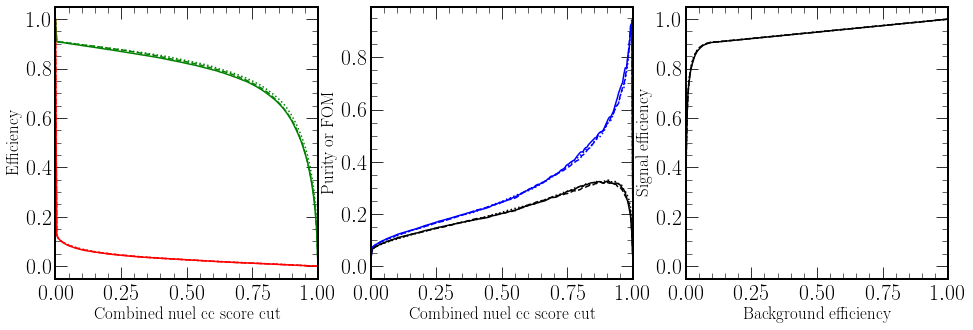

In [28]:
chipsnet.plotting.plot_curves([v_c_flux_out, v_ct_flux_out, v_cth_flux_out], save_path+"channel_curves")

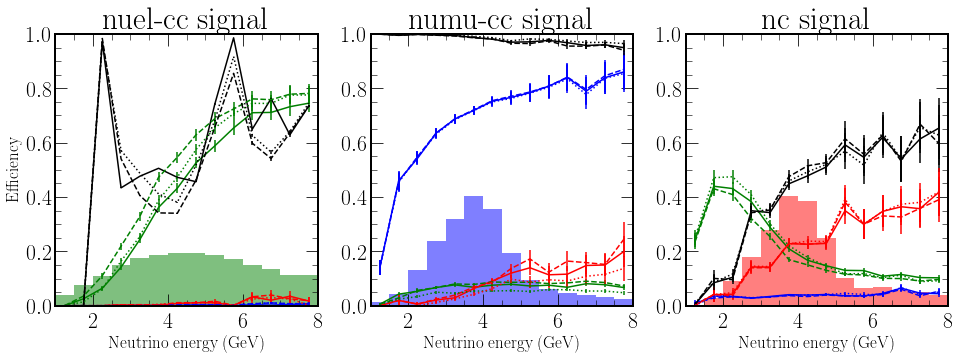

In [29]:
chipsnet.plotting.plot_e_hists([v_c_flux_out, v_ct_flux_out, v_cth_flux_out], v_c_flux_ev, save_path+"channel_hists")

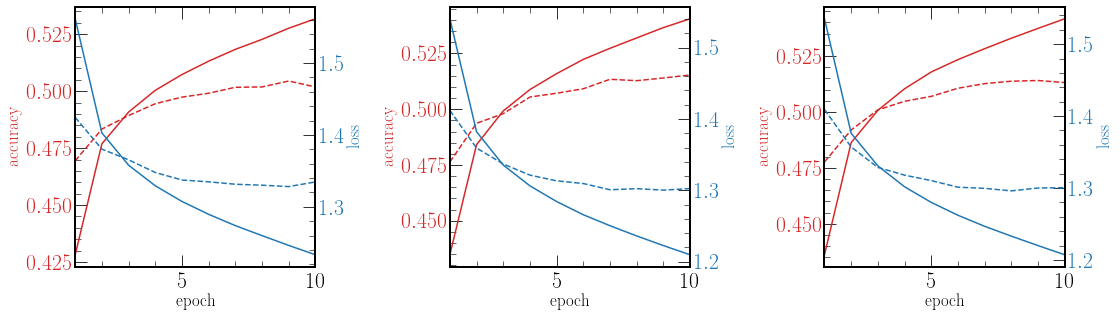

In [30]:
chipsnet.plotting.plot_history_comparison(config, ["beam_v_c", "beam_v_ct", "beam_v_cth"], save_path+"channel_history")

In [31]:
chipsnet.utils.print_output_comparison([v_c_flux_out, v_ct_flux_out, v_cth_flux_out])

Sig eff AUC: [0.7737983377087508, 0.6862747927658374, 0.1821890372567421]
Bkg eff AUC: [0.033755859491382725, 0.032798119323812686, 0.029962061863520472]
Purity AUC: [0.29597749292698183, 0.9899715253678757, 0.5753935676442028]
FOM AUC: [0.2054133071193145, 0.6808513625213075, 0.09466818960101522]
ROC AUC: [0.9407000998448457, 0.8322113121697535, 0.5998207029501572]
              precision    recall  f1-score   support

     nuel-cc       0.93      0.90      0.92     55412
     numu-cc       0.97      0.94      0.95     53880
          nc       0.69      0.81      0.74     18708

    accuracy                           0.90    128000
   macro avg       0.86      0.88      0.87    128000
weighted avg       0.91      0.90      0.91    128000

              precision    recall  f1-score   support

           0       0.43      0.67      0.52     10121
           1       0.50      0.46      0.48     17595
           2       0.77      0.63      0.69     21005
           3       0.10      0.31

In [32]:
# Tidy up
del v_c_flux_ev
del v_c_flux_out
del v_ct_flux_ev
del v_ct_flux_out
del v_cth_flux_ev
del v_cth_flux_out

<a id='section_4'></a>

## Which training sample is best? (beam flux vs uniform)

Looks like the beam flux sample is best. However this seems to be because it has a larger sample of 

In [33]:
v_cth_flux_ev_both, v_cth_flux_out_both = chipsnet.utils.process_ds(config,"v_cth_flux", ["beam_v_cth"])
v_cth_flux_ev_flux, v_cth_flux_out_flux = chipsnet.utils.process_ds(config, "v_cth_flux", ["beam_v_cth_just_flux"])
v_cth_flux_ev_uniform, v_cth_flux_out_uniform = chipsnet.utils.process_ds(config, "v_cth_flux", ["beam_v_cth_just_uniform"])

Processing v_cth_flux... took 147.73 seconds
Processing v_cth_flux... took 146.24 seconds
Processing v_cth_flux... took 148.71 seconds


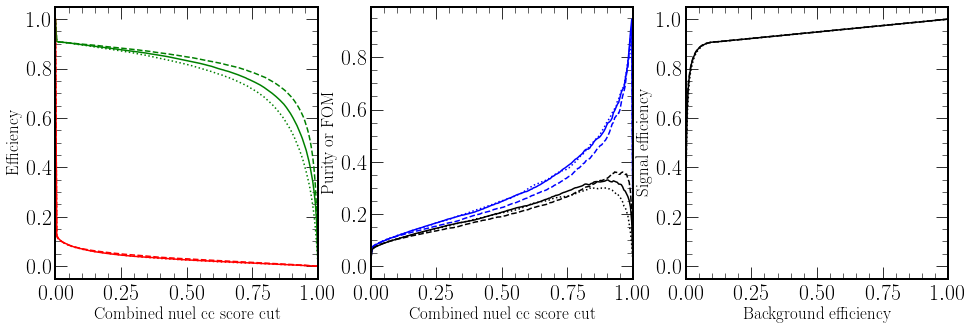

In [34]:
chipsnet.plotting.plot_curves([v_cth_flux_out_both, v_cth_flux_out_flux, v_cth_flux_out_uniform], save_path+"sample_curves")

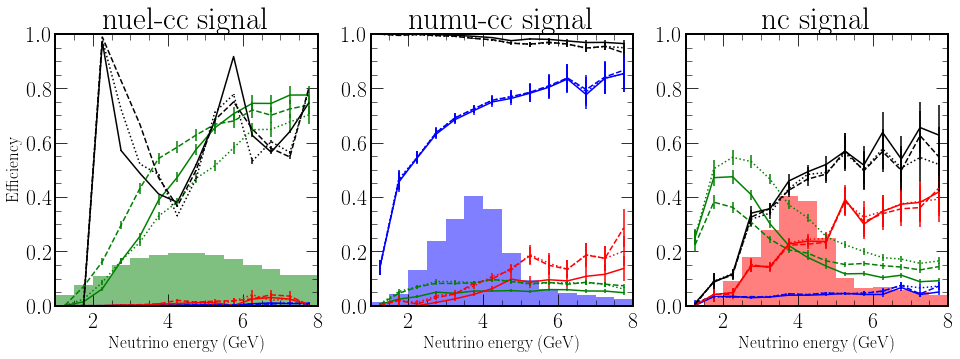

In [35]:
chipsnet.plotting.plot_e_hists([v_cth_flux_out_both, v_cth_flux_out_flux, v_cth_flux_out_uniform], v_cth_flux_ev_flux, save_path+"sample_hists")

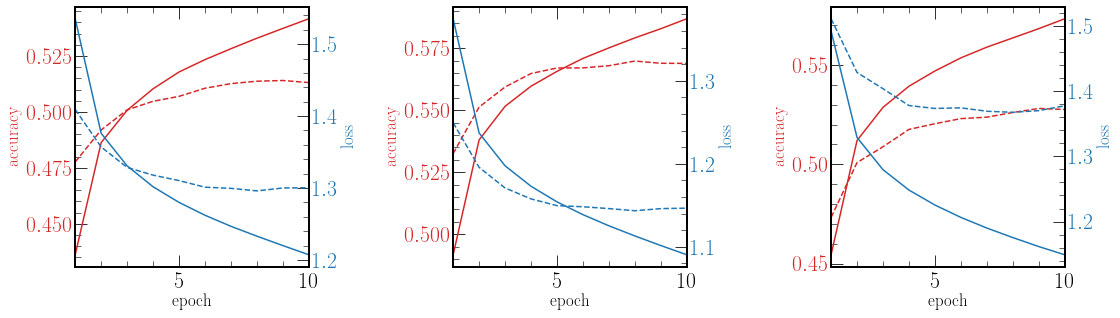

In [36]:
chipsnet.plotting.plot_history_comparison(config, ["beam_v_cth", "beam_v_cth_just_flux", "beam_v_cth_just_uniform"], save_path+"sample_history")

In [37]:
chipsnet.utils.print_output_comparison([v_cth_flux_out_both, v_cth_flux_out_flux, v_cth_flux_out_uniform])

Sig eff AUC: [0.7858327401116157, 0.6865715178921652, 0.1859849711797955]
Bkg eff AUC: [0.03457344922731473, 0.02741779719762065, 0.028905812322920367]
Purity AUC: [0.29169260293310806, 0.9912284897785787, 0.5909564313713305]
FOM AUC: [0.20744816045398823, 0.6820365641363277, 0.09962238304279403]
ROC AUC: [0.9415264350308489, 0.834212578664476, 0.6008243385534857]
              precision    recall  f1-score   support

     nuel-cc       0.93      0.91      0.92     55412
     numu-cc       0.97      0.94      0.96     53880
          nc       0.70      0.81      0.75     18708

    accuracy                           0.91    128000
   macro avg       0.87      0.89      0.88    128000
weighted avg       0.92      0.91      0.91    128000

              precision    recall  f1-score   support

           0       0.43      0.70      0.53     10121
           1       0.52      0.47      0.49     17595
           2       0.77      0.65      0.70     21005
           3       0.11      0.30  

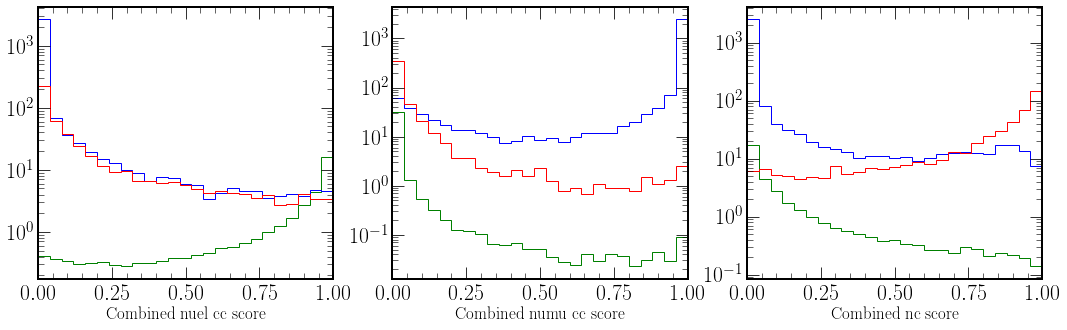

In [38]:
chipsnet.plotting.plot_combined_values(v_cth_flux_ev_both, "beam_v_cth_", save_path+"beam_v_cth_values")

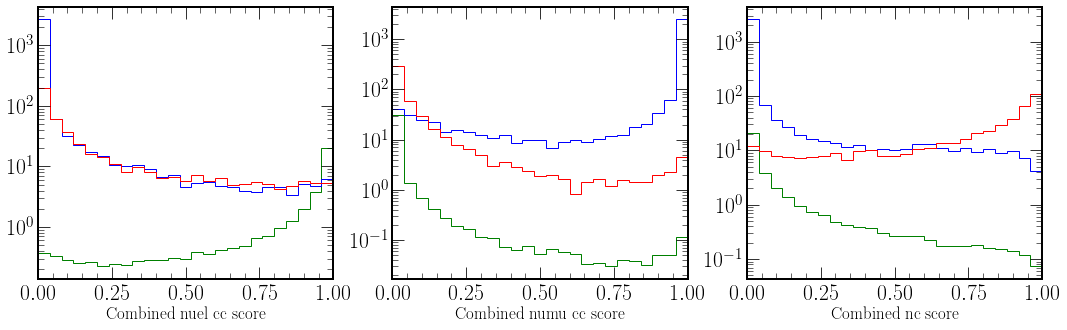

In [39]:
chipsnet.plotting.plot_combined_values(v_cth_flux_ev_flux, "beam_v_cth_just_flux_", save_path+"beam_v_cth_just_flux_values")

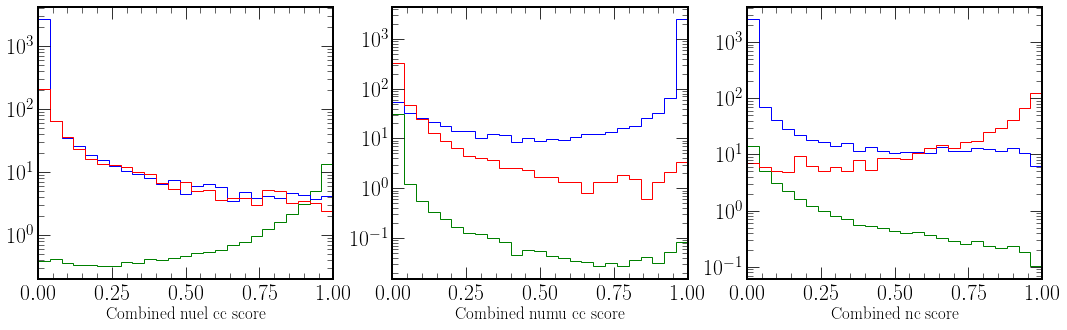

In [40]:
chipsnet.plotting.plot_combined_values(v_cth_flux_ev_uniform, "beam_v_cth_just_uniform_", save_path+"beam_v_cth_just_uniform_values")

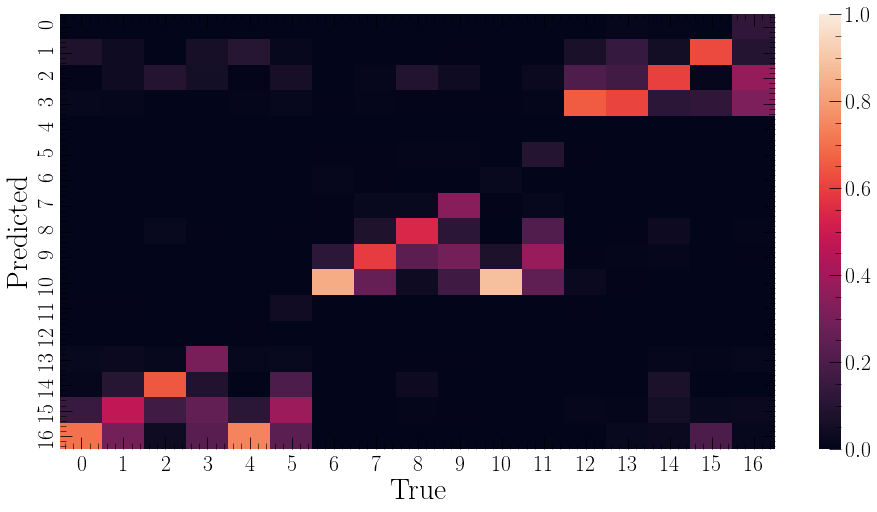

In [41]:
plt.figure(figsize=(16,8))
sns.heatmap(v_cth_flux_out_both["all_matrices"][0], annot=False, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for uniform sample

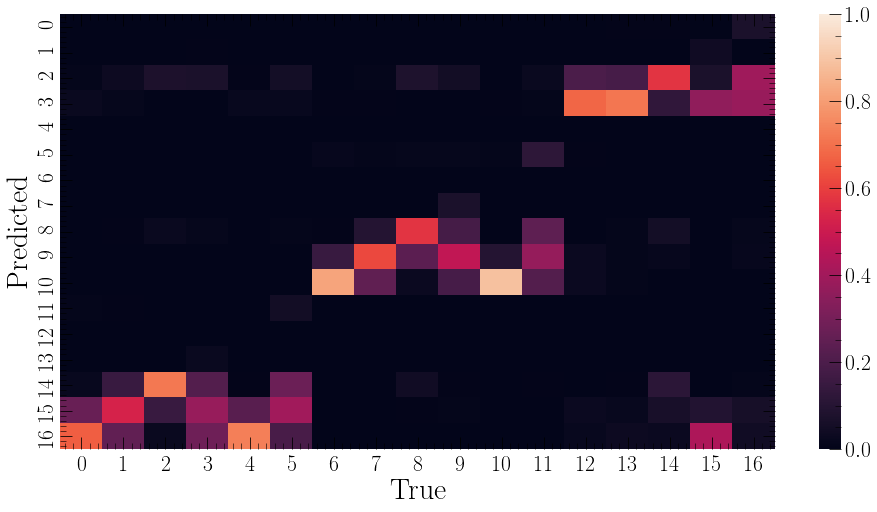

In [42]:
plt.figure(figsize=(16,8))
sns.heatmap(v_cth_flux_out_flux["all_matrices"][0], annot=False, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for uniform sample

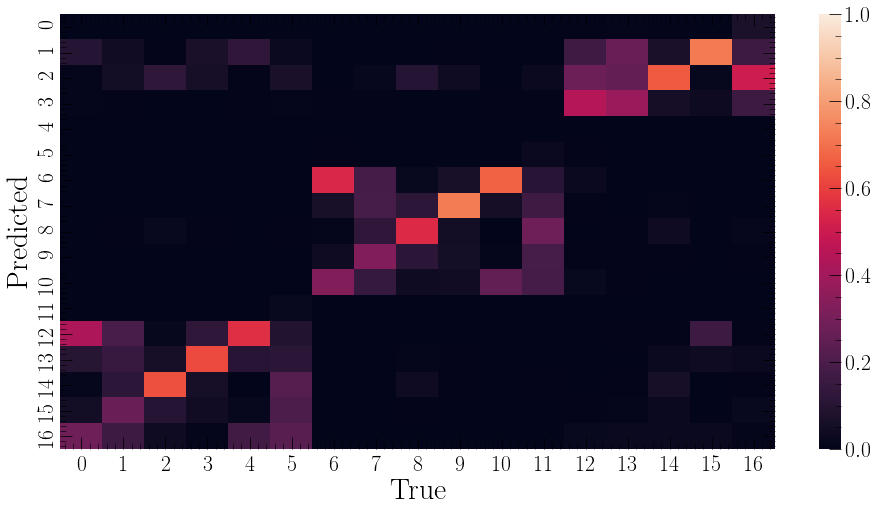

In [43]:
plt.figure(figsize=(16,8))
sns.heatmap(v_cth_flux_out_uniform["all_matrices"][0], annot=False, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for uniform sample

In [44]:
# Tidy up
del v_cth_flux_ev_both
del v_cth_flux_out_both
del v_cth_flux_ev_flux
del v_cth_flux_out_flux
del v_cth_flux_ev_uniform
del v_cth_flux_out_uniform

<a id='section_5'></a>

## Which categorisation works best?

In [45]:
v_cth_flux_all_ev, v_cth_flux_all_out = chipsnet.utils.process_ds(config, "v_cth_flux", ["t_all_cat_v_cth"], ["t_all_cat"])
v_cth_flux_comb_ev, v_cth_flux_comb_out = chipsnet.utils.process_ds(config, "v_cth_flux", ["t_comb_cat_v_cth"], ["t_comb_cat"])
v_cth_flux_nu_nc_ev, v_cth_flux_nu_nc_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["beam_v_cth"], ["t_nu_nc_cat"])
v_cth_flux_nc_ev, v_cth_flux_nc_out = chipsnet.utils.process_ds(config, "v_cth_flux", ["t_nc_cat_v_cth"], ["t_nc_cat"])

Processing v_cth_flux... took 158.81 seconds
Processing v_cth_flux... took 104.71 seconds
Processing v_cth_flux... took 155.27 seconds
Processing v_cth_flux... took 149.14 seconds


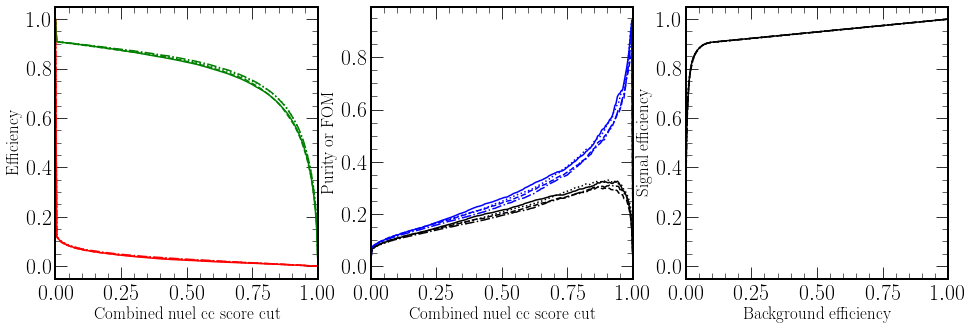

In [46]:
chipsnet.plotting.plot_curves([v_cth_flux_all_out, v_cth_flux_comb_out, v_cth_flux_nu_nc_out, v_cth_flux_nc_out], save_path+"cat_curves")

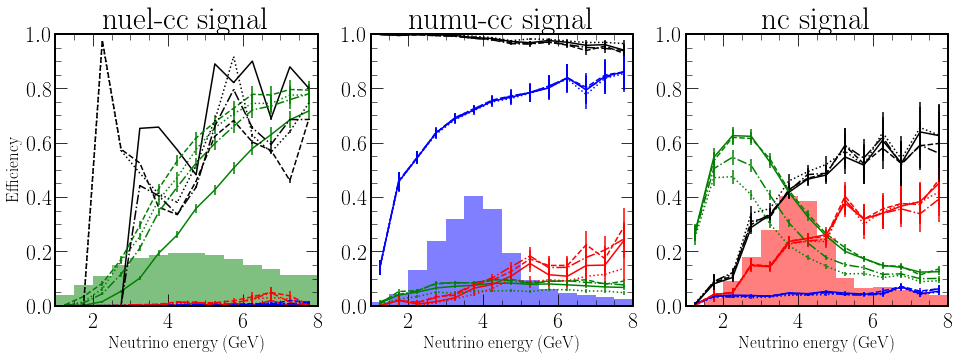

In [47]:
chipsnet.plotting.plot_e_hists([v_cth_flux_all_out, v_cth_flux_comb_out, v_cth_flux_nu_nc_out, v_cth_flux_nc_out], v_cth_flux_all_ev, save_path+"cat_hists")

In [48]:
chipsnet.utils.print_output_comparison([v_cth_flux_all_out, v_cth_flux_comb_out, v_cth_flux_nu_nc_out, v_cth_flux_nc_out])

Sig eff AUC: [0.7773789241587687, 0.6905039755945159, 0.17721082388897597]
Bkg eff AUC: [0.033360820131206226, 0.03758390169960721, 0.026190450752405108]
Purity AUC: [0.2978879759133889, 0.9888915449465184, 0.6100594629251614]
FOM AUC: [0.2087106294307323, 0.6842885111349024, 0.09776234456780236]
ROC AUC: [0.9414873004810657, 0.8312311527656606, 0.6039031938406333]
              precision    recall  f1-score   support

     nuel-cc       0.93      0.91      0.92     55412
     numu-cc       0.96      0.95      0.95     53880
          nc       0.71      0.79      0.75     18708

    accuracy                           0.91    128000
   macro avg       0.87      0.88      0.87    128000
weighted avg       0.91      0.91      0.91    128000

              precision    recall  f1-score   support

           0       0.42      0.74      0.54     10121
           1       0.52      0.45      0.48     17595
           2       0.73      0.69      0.71     21005
           3       0.10      0.31 

In [49]:
# Tidy up
del v_cth_flux_all_ev
del v_cth_flux_all_out
del v_cth_flux_comb_ev
del v_cth_flux_comb_out
del v_cth_flux_nu_nc_ev
del v_cth_flux_nu_nc_out
del v_cth_flux_nc_ev
del v_cth_flux_nc_out

<a id='section_6'></a>

## Different model architectures: which works best.

In [50]:
v_cth_flux_vgg_ev, v_cth_flux_vgg_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["beam_v_cth"])
v_cth_flux_resnet_ev, v_cth_flux_resnet_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["beam_v_cth_resnet"])
v_cth_flux_inception_ev, v_cth_flux_inception_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["beam_v_cth_inception"])

Processing v_cth_flux... took 172.93 seconds
Processing v_cth_flux... took 189.31 seconds
Processing v_cth_flux... took 301.41 seconds


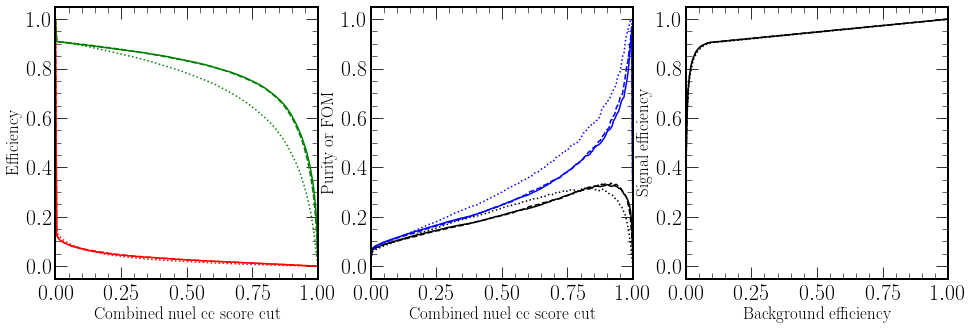

In [51]:
chipsnet.plotting.plot_curves([v_cth_flux_vgg_out, v_cth_flux_resnet_out, v_cth_flux_inception_out], save_path+"model_curves")

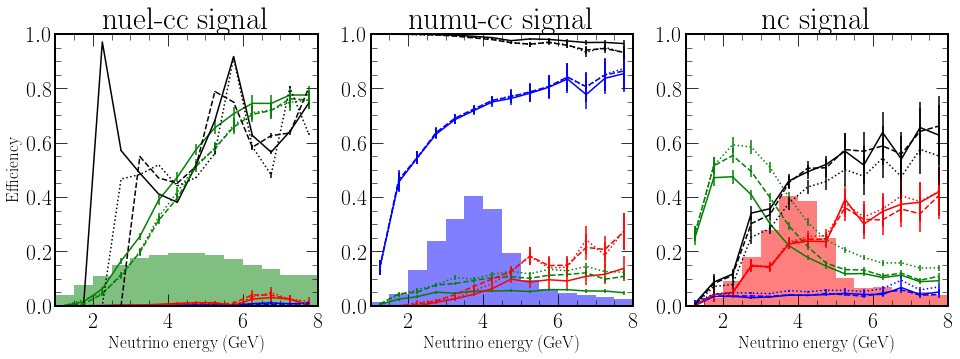

In [52]:
chipsnet.plotting.plot_e_hists([v_cth_flux_vgg_out, v_cth_flux_resnet_out, v_cth_flux_inception_out], v_cth_flux_vgg_ev, save_path+"model_hists")

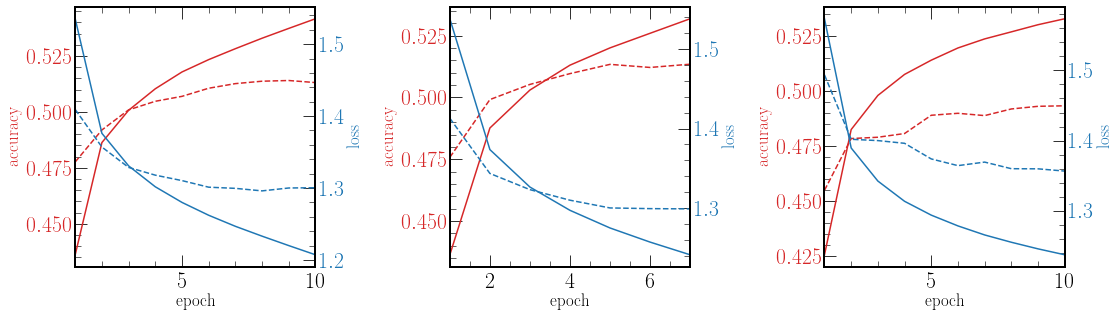

In [53]:
chipsnet.plotting.plot_history_comparison(config, ["beam_v_cth", "beam_v_cth_resnet", "beam_v_cth_inception"], save_path+"model_history")

In [54]:
chipsnet.utils.print_output_comparison([v_cth_flux_vgg_out, v_cth_flux_resnet_out, v_cth_flux_inception_out])

Sig eff AUC: [0.7858327401116157, 0.6865715178921652, 0.1859849711797955]
Bkg eff AUC: [0.03457344922731473, 0.02741779719762065, 0.028905812322920367]
Purity AUC: [0.29169260293310806, 0.9912284897785787, 0.5909564313713305]
FOM AUC: [0.20744816045398823, 0.6820365641363277, 0.09962238304279403]
ROC AUC: [0.9415264350308489, 0.834212578664476, 0.6008243385534857]
              precision    recall  f1-score   support

     nuel-cc       0.93      0.91      0.92     55412
     numu-cc       0.97      0.94      0.96     53880
          nc       0.70      0.81      0.75     18708

    accuracy                           0.91    128000
   macro avg       0.87      0.89      0.88    128000
weighted avg       0.92      0.91      0.91    128000

              precision    recall  f1-score   support

           0       0.43      0.70      0.53     10121
           1       0.52      0.47      0.49     17595
           2       0.77      0.65      0.70     21005
           3       0.11      0.30  

In [55]:
# Tidy up
del v_cth_flux_vgg_ev
del v_cth_flux_vgg_out
del v_cth_flux_resnet_ev
del v_cth_flux_resnet_out
del v_cth_flux_inception_ev
del v_cth_flux_inception_out

<a id='section_7'></a>

## Trying a multi-task model: what to include.

In [56]:
v_cth_flux_multi_ev, v_cth_flux_multi_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["multi_beam_v_cth"])
v_cth_flux_multi_cosmic_ev, v_cth_flux_multi_cosmic_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["multi_beam_cosmic_v_cth"])
v_cth_flux_multi_energy_ev, v_cth_flux_multi_energy_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["multi_beam_energy_v_cth"])
v_cth_flux_multi_vertex_ev, v_cth_flux_multi_vertex_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["multi_beam_vertex_v_cth"])

# multi_beam_v_cth: ["t_nu_nc_cat", "t_all_cat", "t_comb_cat", "t_int_type"]
# multi_beam_cosmic_v_cth: ["t_nu_nc_cat", "t_all_cat", "t_comb_cat", "t_int_type", "t_cosmic_cat"]
# multi_beam_energy_v_cth: ["t_nu_nc_cat", "t_all_cat", "t_comb_cat", "t_int_type", "t_nuEnergy"]
# multi_beam_vertex_v_cth: ["t_nu_nc_cat", "t_all_cat", "t_comb_cat", "t_int_type", "t_vtxX", "t_vtxY", "t_vtxZ"]

Processing v_cth_flux... took 151.33 seconds
Processing v_cth_flux... took 154.57 seconds
Processing v_cth_flux... took 160.32 seconds
Processing v_cth_flux... took 152.67 seconds


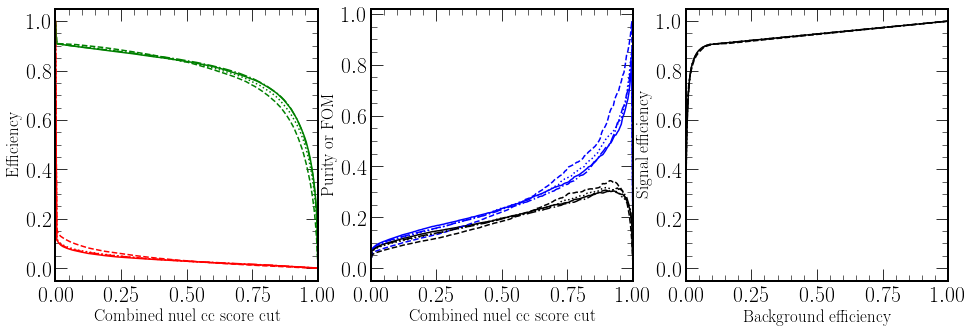

In [57]:
chipsnet.plotting.plot_curves(
    [v_cth_flux_multi_out, v_cth_flux_multi_cosmic_out, v_cth_flux_multi_energy_out, v_cth_flux_multi_vertex_out], 
    save_path+"multi_curves")

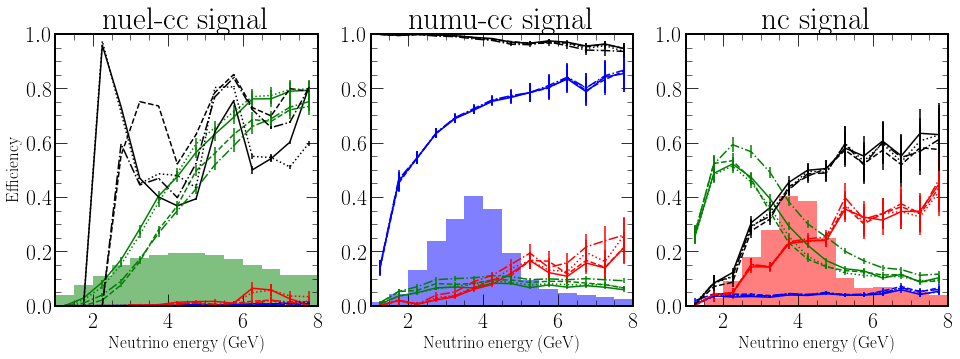

In [58]:
chipsnet.plotting.plot_e_hists(
    [v_cth_flux_multi_out, v_cth_flux_multi_cosmic_out, v_cth_flux_multi_energy_out, v_cth_flux_multi_vertex_out],
    v_cth_flux_multi_ev, 
    save_path+"multi_hists")

In [59]:
chipsnet.utils.print_output_comparison([v_cth_flux_multi_out, v_cth_flux_multi_cosmic_out, v_cth_flux_multi_energy_out, v_cth_flux_multi_vertex_out])

Sig eff AUC: [0.7944371408728684, 0.6901455554659746, 0.17687007216312503]
Bkg eff AUC: [0.034849019752779355, 0.03388816988991677, 0.025352348650251256]
Purity AUC: [0.2685976904134591, 0.9897097632063185, 0.5966456988372995]
FOM AUC: [0.1974017460912702, 0.6845338253056943, 0.09767610042939101]
ROC AUC: [0.9411568185383578, 0.8330179433648531, 0.6102460618734086]
              precision    recall  f1-score   support

     nuel-cc       0.92      0.92      0.92     55412
     numu-cc       0.97      0.94      0.95     53880
          nc       0.72      0.78      0.75     18708

    accuracy                           0.91    128000
   macro avg       0.87      0.88      0.87    128000
weighted avg       0.91      0.91      0.91    128000

              precision    recall  f1-score   support

           0       0.43      0.68      0.53     10121
           1       0.52      0.44      0.48     17595
           2       0.74      0.68      0.71     21005
           3       0.09      0.31 

In [60]:
# Tidy up
del v_cth_flux_multi_ev
del v_cth_flux_multi_out
del v_cth_flux_multi_cosmic_ev
del v_cth_flux_multi_cosmic_out
del v_cth_flux_multi_energy_ev
del v_cth_flux_multi_energy_out
del v_cth_flux_multi_vertex_ev
del v_cth_flux_multi_vertex_out

<a id='section_8'></a>

## Model calibration sensitivity: can we shift things up and down?

In [61]:
v_cth_flux_ev, v_cth_flux_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["beam_v_cth"])
v_cth_flux_5_ev, v_cth_flux_5_out = chipsnet.utils.process_ds(config,"v_cth_flux_5", ["beam_v_cth"])
v_cth_flux_10_ev, v_cth_flux_10_out = chipsnet.utils.process_ds(config,"v_cth_flux_10", ["beam_v_cth"])
v_cth_flux_20_ev, v_cth_flux_20_out = chipsnet.utils.process_ds(config,"v_cth_flux_20", ["beam_v_cth"])

Processing v_cth_flux... took 149.03 seconds
Processing v_cth_flux_5... took 178.90 seconds
Processing v_cth_flux_10... took 156.66 seconds
Processing v_cth_flux_20... took 147.44 seconds


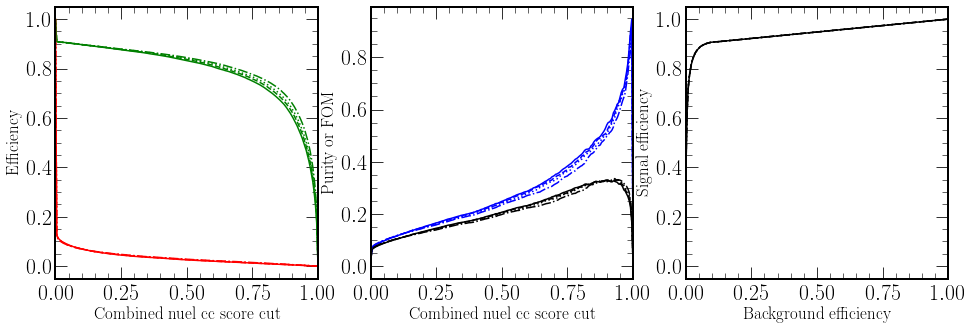

In [62]:
chipsnet.plotting.plot_curves([v_cth_flux_out, v_cth_flux_5_out, v_cth_flux_10_out, v_cth_flux_20_out], save_path+"calibration_curves")

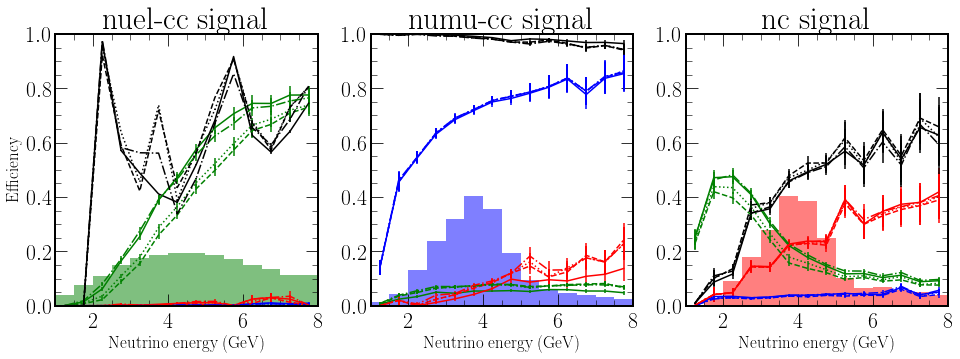

In [63]:
chipsnet.plotting.plot_e_hists([v_cth_flux_out, v_cth_flux_5_out, v_cth_flux_10_out, v_cth_flux_20_out], v_cth_flux_ev, save_path+"calibration_hists")

In [64]:
chipsnet.utils.print_output_comparison([v_cth_flux_out, v_cth_flux_5_out, v_cth_flux_10_out, v_cth_flux_20_out])

Sig eff AUC: [0.7858327401116157, 0.6865715178921652, 0.1859849711797955]
Bkg eff AUC: [0.03457344922731473, 0.02741779719762065, 0.028905812322920367]
Purity AUC: [0.29169260293310806, 0.9912284897785787, 0.5909564313713305]
FOM AUC: [0.20744816045398823, 0.6820365641363277, 0.09962238304279403]
ROC AUC: [0.9415264350308489, 0.834212578664476, 0.6008243385534857]
              precision    recall  f1-score   support

     nuel-cc       0.93      0.91      0.92     55412
     numu-cc       0.97      0.94      0.96     53880
          nc       0.70      0.81      0.75     18708

    accuracy                           0.91    128000
   macro avg       0.87      0.89      0.88    128000
weighted avg       0.92      0.91      0.91    128000

              precision    recall  f1-score   support

           0       0.43      0.70      0.53     10121
           1       0.52      0.47      0.49     17595
           2       0.77      0.65      0.70     21005
           3       0.11      0.30  

In [65]:
# Tidy up
del v_cth_flux_ev
del v_cth_flux_out
del v_cth_flux_5_ev
del v_cth_flux_5_out
del v_cth_flux_10_ev
del v_cth_flux_10_out
del v_cth_flux_20_ev
del v_cth_flux_20_out

<a id='section_9'></a>

## Neutrino energy estimation

In [ ]:
nuel_cccoh_energy
nuel_ccdis_energy
nuel_ccqel_energy
nuel_ccres_energy
nuel_ccmec_energy
numu_cccoh_energy
numu_ccdis_energy
numu_ccqel_energy
numu_ccres_energy
numu_ccmec_energy
nuel_cc_energy
numu_cc_energy
nc_energy

<a id='section_10'></a>

## Explanation clustering: PCA and t-SNE.

In [66]:
v_cth_uniform_ev, v_cth_uniform_out = chipsnet.utils.process_ds(config, "v_cth_uniform", ["beam_v_cth"])

Processing v_cth_uniform... took 148.51 seconds


In [67]:
pca_model = chipsnet.utils.model_from_conf(config, "beam_v_cth")
v_cth_uniform_ev = chipsnet.utils.run_pca(v_cth_uniform_ev, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 0]
cat_1_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 1]
cat_2_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 2]

Explained variation per principal component: [0.14903172 0.13979793]


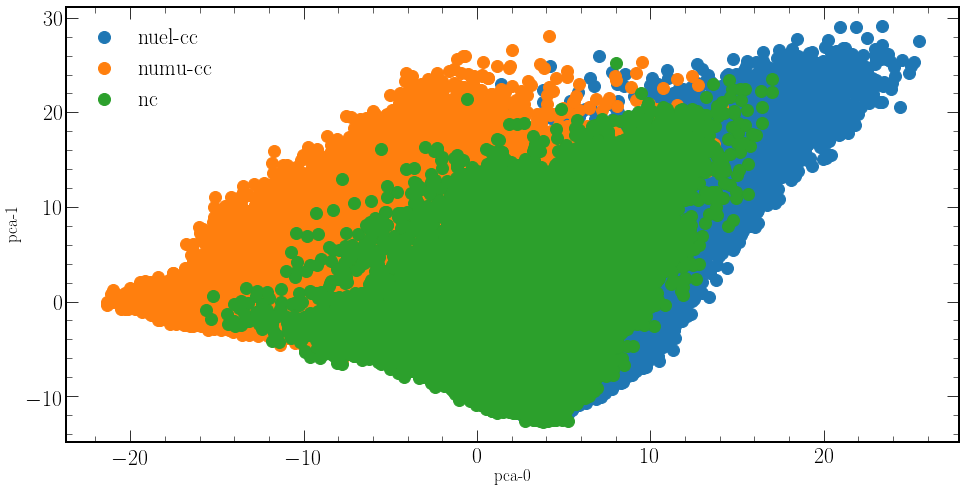

In [68]:
fig, axs = plt.subplots(1, 1, figsize=(16, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.pca_0, cat_0_ev.pca_1, marker='o', linestyle='', ms=12, label="nuel-cc")
axs.plot(cat_1_ev.pca_0, cat_1_ev.pca_1, marker='o', linestyle='', ms=12, label="numu-cc")
axs.plot(cat_2_ev.pca_0, cat_2_ev.pca_1, marker='o', linestyle='', ms=12, label="nc")
axs.legend()
axs.set_xlabel('pca-0', fontsize=17)
axs.set_ylabel('pca-1', fontsize=17)
save("pca")

In [69]:
tsne_model = chipsnet.utils.model_from_conf(config, "beam_v_cth")
v_cth_uniform_ev = chipsnet.utils.run_tsne(v_cth_uniform_ev, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 0]
cat_1_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 1]
cat_2_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 2]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.063s...
[t-SNE] Computed neighbors for 10000 samples in 68.796s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.846844
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.138718
[t-SNE] KL divergence after 300 iterations: 2.575065


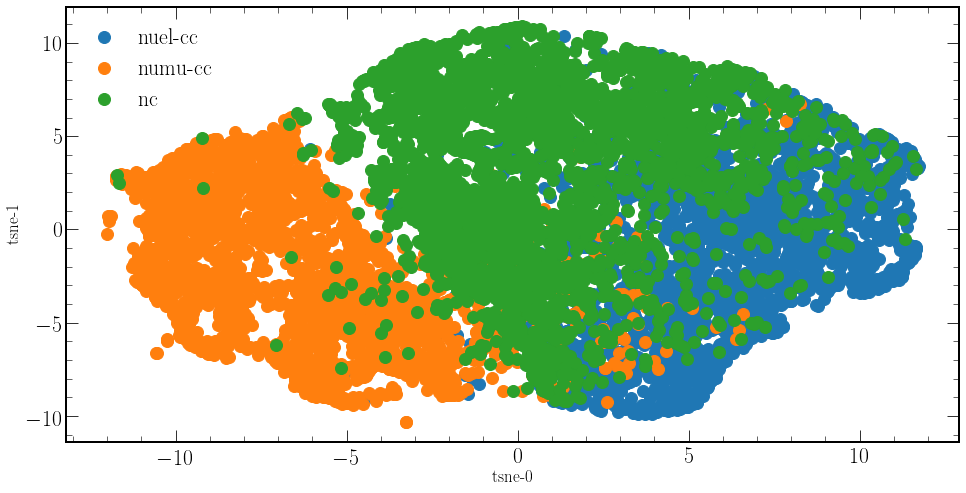

In [70]:
fig, axs = plt.subplots(1, 1, figsize=(16, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne_0, cat_0_ev.tsne_1, marker='o', linestyle='', ms=12, label="nuel-cc")
axs.plot(cat_1_ev.tsne_0, cat_1_ev.tsne_1, marker='o', linestyle='', ms=12, label="numu-cc")
axs.plot(cat_2_ev.tsne_0, cat_2_ev.tsne_1, marker='o', linestyle='', ms=12, label="nc")
axs.legend()
axs.set_xlabel('tsne-0', fontsize=17)
axs.set_ylabel('tsne-1', fontsize=17)
save("tsne")

In [71]:
# Tidy up
del v_cth_uniform_ev
del v_cth_uniform_out

<a id='section_11'></a>

## Explanation activations

In [79]:
v_cth_uniform_ev, v_cth_uniform_out = chipsnet.utils.process_ds(config, "v_cth_flux_stacked_noreco")

Processing v_cth_flux_stacked_noreco... took 27.81 seconds


In [80]:
grad_cam_model = chipsnet.utils.model_from_conf(config, "beam_v_cth_stacked_noreco")
grad_cams_1 = chipsnet.utils.explain_gradcam(v_cth_uniform_ev, grad_cam_model, 10, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
grad_cams_2 = chipsnet.utils.explain_gradcam(v_cth_uniform_ev, grad_cam_model, 10, output="t_nu_nc_cat", layer_name="block2_conv1")
grad_cams_3 = chipsnet.utils.explain_gradcam(v_cth_uniform_ev, grad_cam_model, 10, output="t_nu_nc_cat", layer_name="block3_conv1")

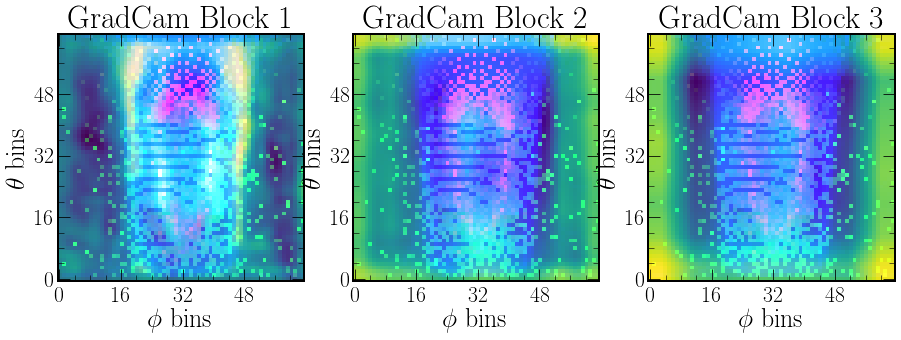

In [81]:
event = 2
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(grad_cams_1[event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(grad_cams_2[event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(grad_cams_3[event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
save("grad_cam")

In [82]:
activation_model = chipsnet.utils.model_from_conf(config, "beam_v_cth_stacked_noreco")
activations_1 = chipsnet.utils.explain_activation(v_cth_uniform_ev, activation_model, 10, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
activations_2 = chipsnet.utils.explain_activation(v_cth_uniform_ev, activation_model, 10, output="t_nu_nc_cat", layer_name="block2_conv1")
activations_3 = chipsnet.utils.explain_activation(v_cth_uniform_ev, activation_model, 10, output="t_nu_nc_cat", layer_name="block3_conv1")

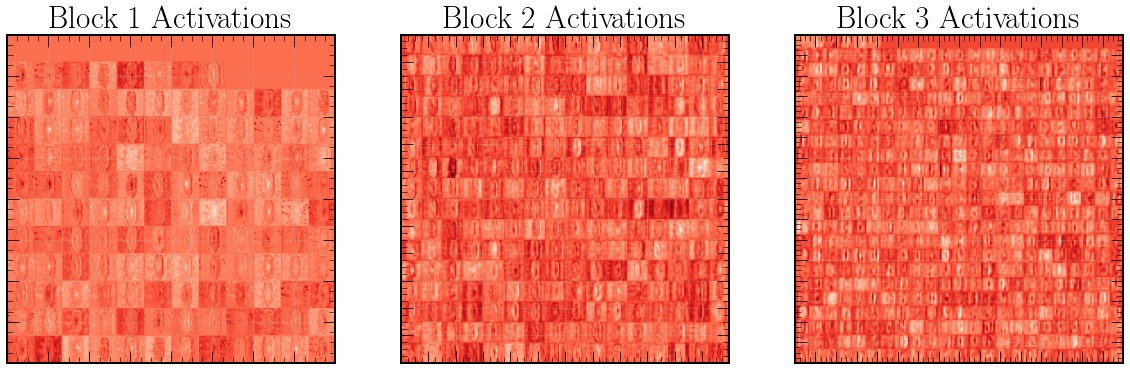

In [83]:
event = 1
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
plt.rc('grid', linestyle="-", color='black')

axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
extent = (0, 256, 256, 0)
axs[0].imshow(activations_1[event], cmap='Reds', origin='lower', extent=extent)
axs[0].set_title('Block 1 Activations')
axs[0].grid()

extent = (0, 192, 192, 0)
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(activations_2[event], cmap='Reds', origin='lower', extent=extent)
axs[1].set_title('Block 2 Activations')
axs[1].grid()

extent = (0, 128, 128, 0)
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(activations_3[event], cmap='Reds', origin='lower', extent=extent)
axs[2].set_title('Block 3 Activations')
axs[2].grid()

save("activations")

In [84]:
# Tidy up
del v_cth_uniform_ev
del v_cth_uniform_out

<a id='section_12'></a>

## Final model/models performance and comparison with lagacy reco and PID